In [1]:
import os 
import sys
from os import listdir
from os.path import isfile, join
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import trange, tqdm
import skimage
from skimage import io
from pathlib import Path
import re
from skimage import exposure
import h5py
import cv2 as cv
from skimage.util import img_as_ubyte, invert
from skimage import exposure
from skimage.transform import rescale


In [2]:
p_dir = (Path().cwd().parents[0]).absolute()

In [3]:
%load_ext autoreload
%autoreload 2

module_path = str(p_dir / "src")

if module_path not in sys.path:
    sys.path.append(module_path)

import utils as my_utils

In [4]:
match_info_dir = p_dir / 'data' / 'registration'
experiment = 'Tonsil'
core = 'DonorA'

# Read HE and IMC large area

In [67]:
from skimage.transform import rotate

h5_data_dir = p_dir / "data" / "h5"

def get_imgs(experiment, name):
    with h5py.File(h5_data_dir / f"{experiment}.hdf5", "r") as f:
        imgs = f[name][:]
        labels = list(f[name].attrs["markers"])
    return imgs, labels

def contrast_stretching(img):
    # Contrast stretching
    p2, p98 = np.percentile(img, (2, 98))
    img_rescale = exposure.rescale_intensity(
        img, in_range=(p2, p98), out_range=(0, 255)
    ).astype(np.uint8)
    return img_rescale

def crop_img(img, info, rotation_imc=90):
    # Rotate img
    bbox = info["bbox"]
    rotation = info["rotation"]
    bbox_r = info["bbox_r"]
    
    y, h_region, x, w_region = np.array(bbox) + np.array([-20, 20, -20, 20])
    img = rotate(img[y:y+h_region, x:x+w_region], (rotation_imc+rotation))
    y, h_region, x, w_region = np.array(bbox_r)
    img = img[y:y+h_region, x:x+w_region,:]
    return img

In [19]:
# REad HE
he_resolution =  0.37744 # um/pixel

HE_path = p_dir / 'data' / 'HE' 
img_he_path = HE_path / f'{core}.tif'

img_he_rgb = io.imread(img_he_path, as_gray=False)
img_he_rgb_rescale = rescale(img_he_rgb, he_resolution, multichannel=True)



C:\Users\thu71\AppData\Local\Temp\ipykernel_18004\3759281846.py:8: FutureWarning: `multichannel` is a deprecated argument name for `rescale`. It will be removed in version 1.0. Please use `channel_axis` instead.
  img_he_rgb_rescale = rescale(img_he_rgb, he_resolution, multichannel=True)


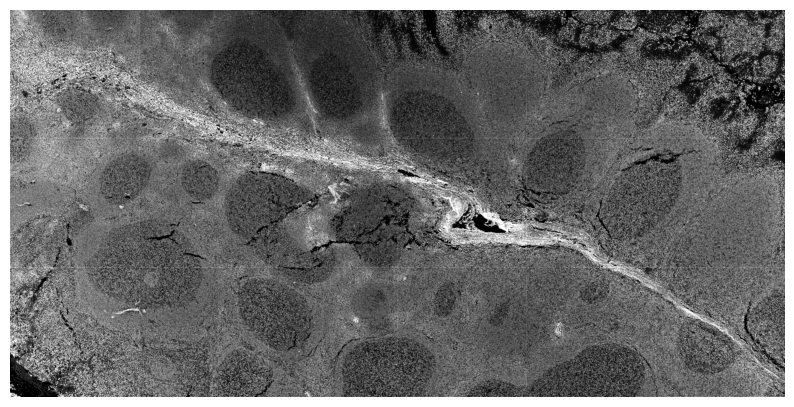

In [57]:
# Read IMC

imgs, markers = get_imgs(f"{experiment} {core}", "IMC")
# subset = ["HistoneH3", 'SMA', 'COL1', 'DNA1']
# subset = ['COL1', 'DNA1', 'DNA2', 'Ki67', 'CD21', 'Vimentin']
subset = ['COL1', 'DNA1', 'DNA2', 'Vimentin']
img_dapi = np.max(contrast_stretching(imgs[[markers.index(marker) for marker in subset]]), axis=0)
img_dapi = contrast_stretching(img_dapi, )

rotation_imc = 90
img_h3 = rotate(img_dapi, rotation_imc, resize=True)
img_h3 = img_h3

fig, ax = plt.subplots(figsize=(10,10))
ax.imshow(img_h3, cmap='gray')
ax.axis('off')
plt.show()

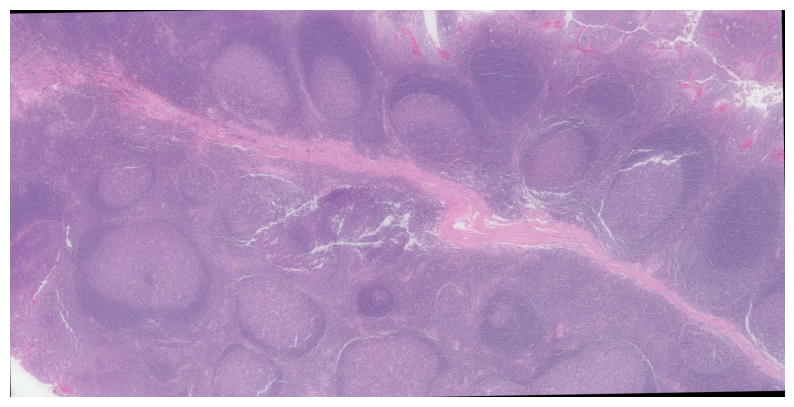

In [68]:
info = my_utils.load_pkl(match_info_dir / f'{core}_HE_IMC.pickle')
img = crop_img(img_he_rgb_rescale, info, rotation_imc=rotation_imc)

fig, ax = plt.subplots(figsize=(10,10))
ax.imshow(img, cmap='gray')
ax.axis('off')
plt.show()

In [69]:
from skimage.registration import phase_cross_correlation
from skimage.transform import warp_polar, rotate, rescale
import matplotlib.patches as mpatches
from collections import Counter
import matplotlib.offsetbox
from matplotlib.lines import Line2D

class AnchoredHScaleBar(matplotlib.offsetbox.AnchoredOffsetbox):
    """ size: length of bar in data units
        extent : height of bar ends in axes units """
    def __init__(self, size=1, extent = 0.03, label="", loc=2, ax=None,
                 pad=0.4, borderpad=0.5, ppad = 0, sep=2, prop=None, 
                 frameon=True, linekw={}, textprops={}, **kwargs):
        if not ax:
            ax = plt.gca()
        trans = ax.get_xaxis_transform()
        size_bar = matplotlib.offsetbox.AuxTransformBox(trans)
        line = Line2D([0,size],[0,0], **linekw)
        vline1 = Line2D([0,0],[-extent/2.,extent/2.], **linekw)
        vline2 = Line2D([size,size],[-extent/2.,extent/2.], **linekw)
        size_bar.add_artist(line)
        size_bar.add_artist(vline1)
        size_bar.add_artist(vline2)
        txt = matplotlib.offsetbox.TextArea(label, textprops=textprops)
        self.vpac = matplotlib.offsetbox.VPacker(children=[size_bar,txt],  
                                 align="center", pad=ppad, sep=sep) 
        matplotlib.offsetbox.AnchoredOffsetbox.__init__(self, loc, pad=pad, 
                 borderpad=borderpad, child=self.vpac, prop=prop, frameon=frameon,
                 **kwargs)


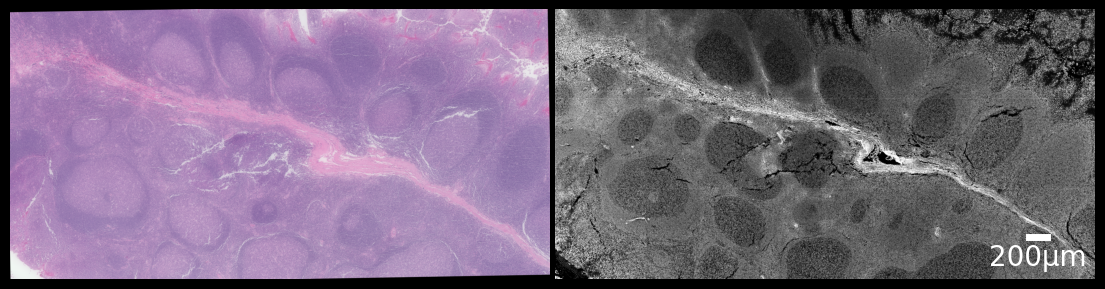

In [70]:
fig, ax = plt.subplots(1, 2, figsize=(14,7), facecolor='black')
ax[0].imshow(img)
ax[1].imshow(img_h3, cmap='gray')
ax[0].axis('off')
ax[1].axis('off')
# Add Scale Bar
ob = AnchoredHScaleBar(size=200, label="200\u03BCm", loc=4, frameon=False, extent=0.,
               pad=0.1,sep=4, linekw=dict(color="w", linewidth=5), textprops=dict(color='w',fontsize=20))
ax[1].add_artist(ob)
fig.subplots_adjust(wspace=0.01)
plt.show()

## Save image
file_path = Path.cwd().parent / 'figures' / 'HE_registration' / f'{core}_2.png'
fig.savefig(file_path, dpi=500, bbox_inches='tight', pad_inches=0)